# Sound Classification for behaviour analysis.

In this notebook, ten different types of sounds are used to create a classifier capable to classify these sounds. The purpose of creating this model is to help identify anti-social and criminal behaviour from sound clips. In this notebook, we will first do some important EDA on these sounds to know what we are dealing with. After this we will be extracting features from these sound waves and perform some preprecessing techniques to createa dataset that we can use to train our model. We will try to use various models and hyper parameters to obtain the best results.

## EDA - Exploratory data analysis:

In [16]:
#Import important libraries
import pandas as pd
import IPython.display as ipd
import librosa
import librosa.display
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

The metadata for these sound clips is also available which provide us with a lot of information related to our audio signals and can be used for the EDA. For this purpose, we will import the CSV file containing the metadata into a pandas dataframe to visualize it properly. After this, we can see the number of files, various classses, salience and start and end points of the individual clips from the original clip, as the audios available are are clippings from longer audios.

In [17]:
# Import the CSV file in pandas dataframe

In [18]:
df = pd.read_csv('./UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


The shape of the folder tells us that there are total 8732 audio files present in the dataset.

In [19]:
df.shape

(8732, 8)

There are 5702 files with salience value of 1, while the remaining 3030 files have salience value of 2. The files with salience 1 are present in the foreground channel and the others are in the background channel.

In [20]:
df['salience'].value_counts()

1    5702
2    3030
Name: salience, dtype: int64

We can also observe that the data is already labeled and Class IDs are assigned to the 10 classes as shown below.

In [21]:
cls_df = df.groupby(['class', 'classID']).nunique()
cls_df.iloc[:, :0]

,
class,classID
air_conditioner,0
car_horn,1
children_playing,2
dog_bark,3
drilling,4
engine_idling,5
gun_shot,6
jackhammer,7
siren,8


The fsID will tell us about the original files. The fsIDs are the base files from whcih the short clips are derived. The total count of fsID column is 1297, which means that there are 1297 main files from which the other files are taken out.

In [22]:
df['fsID'].value_counts()

24347     100
180937     95
72259      73
203929     72
62837      66
         ... 
196065      1
196064      1
196062      1
196061      1
100032      1
Name: fsID, Length: 1297, dtype: int64

To check the imbalnce in the data, we need to see the number of instances present for each class type. It is observable that all the classes have 1000 instances excepth the sciren, car horn and gun shot. After we split the data we will check the values again and if there is any imbalance in the training set, we can balance  it by using smote on the extracted features. A graphical representation of the distribution is also provided below

In [23]:
count=df['class'].value_counts()
Dist=pd.DataFrame({'Class Label':list(count.keys()),
                   'Instances':list(count)})
Dist

,Class Label,Instances
0,dog_bark,1000
1,children_playing,1000
2,air_conditioner,1000
3,street_music,1000
4,engine_idling,1000
5,jackhammer,1000
6,drilling,1000
7,siren,929
8,car_horn,429
9,gun_shot,374


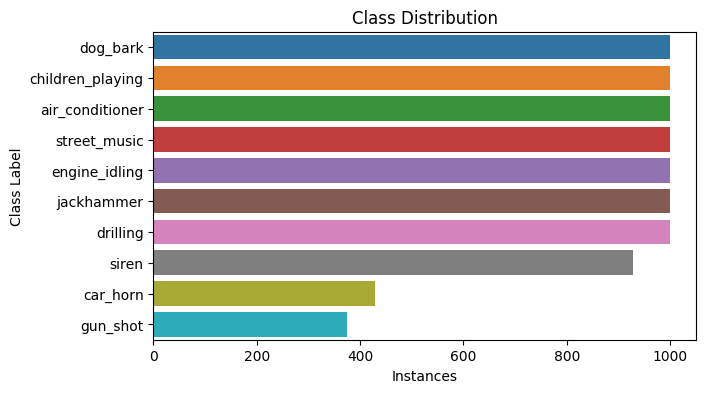

In [39]:
plt.figure(figsize=(7, 4))
plt.title('Class Distribution')
sns.barplot(x=Dist['Instances'],
           y=Dist['Class Label']);
plt.show()

### Signal observation

After having a birds eye view of the datset, we need to go ahead and check the actual file and see how the signals look like. We will be taking one of the files (first one, barking dog) to observe the time domain signal created by this file.

In [99]:
filename='./audio/fold5/100032-3-0-0.wav'

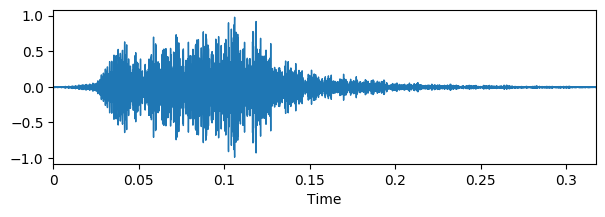

In [100]:
plt.figure(figsize=(7,2))
data,sample_rate=librosa.load(filename)
librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)
plt.show()

A key thing to note is that we have used librosa here to read the audio siganl. The sample rate that librosa uses to sample the signals is 22050 by default. If we use wav.read instead of librosa, the sameple rate will be different.

In [101]:
sample_rate

22050

In [102]:
wave_sample_rate, wave_audio=wav.read(filename)

In [103]:
wave_sample_rate

44100

Also as we discussed earlier, there are two channels in the signal, foreground and background, we can view both of them. Librosa tends to combine both the channels and create a singal audio signal and we will be interested in using signal as created by librosa here.

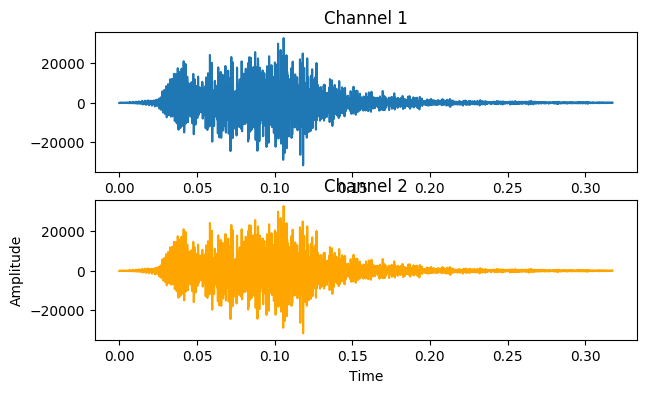

In [104]:
fig, axs = plt.subplots(2)
fig.set_figheight(4)
fig.set_figwidth(7)

length = wave_audio.shape[0] / wave_sample_rate
time = np.linspace(0., length, wave_audio.shape[0])
axs[0].plot(time,wave_audio[:,0])
axs[1].plot(time,wave_audio[:,1],color='orange')

plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.xlabel("Time")
plt.ylabel("Amplitude")

axs[0].set_title('Channel 1')
axs[1].set_title('Channel 2')
plt.show()

After observing the time domain signal, we can also have a look at the Frequency domain aswell using a fast fourier transform. These are helpful as every class has a different frequency and can be helpful in training the model. The other thing that we can get from the FFT is the cepstrum of the audio signal. For the ease of observation, we can also plot these as given below. More on the frequency domain signals and cepstrum will be discussed in the feature extracion part.

In [105]:
# Creating power spectrum (FFT)
X_fft = np.fft.fft(data)
X_spec = (np.absolute(X_fft))
f = np.linspace(0, sample_rate, len(X_spec))
f_bins = int(len(X_spec)*10) 

# Creating cepstrum (IFFT)
X_ifft = np.fft.ifft(X_spec)
X_ceps = np.absolute(X_ifft)
q = np.linspace(0, sample_rate/1000, len(X_ceps))

Text(0, 0.5, 'Magnitude')

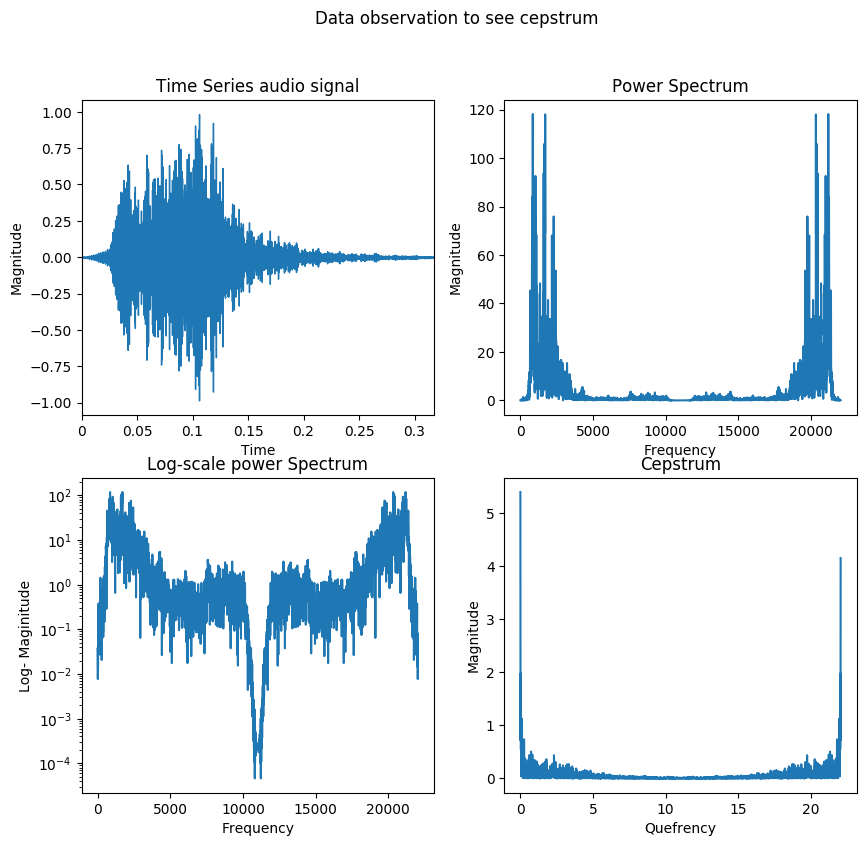

In [108]:

# Plotting using subplots
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False)
fig.set_figheight(9)
fig.set_figwidth(10)

# Plots
librosa.display.waveplot(data, sr = sample_rate, ax=ax[0, 0]) 
ax[0, 1].plot(f[:f_bins], X_spec[:f_bins])
ax[1, 0].plot(f[:f_bins], X_spec[:f_bins])
ax[1, 0].set_yscale("log")
ax[1, 1].plot(q, X_ceps)

# Titles
fig.suptitle('Data observation to see cepstrum')
ax[0, 0].set_title('Time Series audio signal')
ax[0, 1].set_title('Power Spectrum')
ax[1, 0].set_title('Log-scale power Spectrum')
ax[1, 1].set_title('Cepstrum')

# Labels
ax[0, 1].set_xlabel('Frequency')
ax[1, 0].set_xlabel('Frequency')
ax[1, 1].set_xlabel('Quefrency')
ax[0, 0].set_ylabel('Magnitude')
ax[0, 1].set_ylabel('Magnitude')
ax[1, 0].set_ylabel('Log- Maginitude')
ax[1, 1].set_ylabel('Magnitude')

## Pre-processing

For the preprcessing we will be using the spectrographs and MFCCs to help us observe and then extract features out of these audio signals. As we said earlier, ceptsrum plays an imortant role in frequency domin analysis of signals. Cepstrum is a mathematical method used in signal processing to examine a signal's spectral properties. It includes creating a cepstrum by applying the Fourier transform to the logarithm of the signal's Fourier transform's magnitude. The cepstrum can be used to distinguish a signal's numerous components, such as the vocal tract resonances in speech, and to extract information about a signal's periodicity. Similarly, a spectrogram is a graphic representation of the audio data that shows the waveform's signal strength at various frequencies. Usually, a heatmap is used to represent it. In this task, we will take a look the Mel-spectrogram and Mel Frequency Cepstral Coeffecients to see if we can use these values as our features.  

### Spectrograms

The first thing that we need to consider while dealing with audio signals, as discussed previously, is that every signal has its own specific range of frequencies, Spectrogramsa re a good way to analyze this as we can visually observe the signal in three dimentios: time, frequency and amplitude. To get a spectrogram, we need to calculate the short fourier transform of the audio signal.

In [109]:
stft = librosa.stft(data)
type(stft[0][0])

numpy.complex64

The stft as shown above is an array of complex numbers. For this reason, we need to take square of the absolute values for the stft and then use librosa's specshow feature to observe a spectogram. To get a better understanding of the signal we can scale the amplitude of the signal into logarithmic scale.

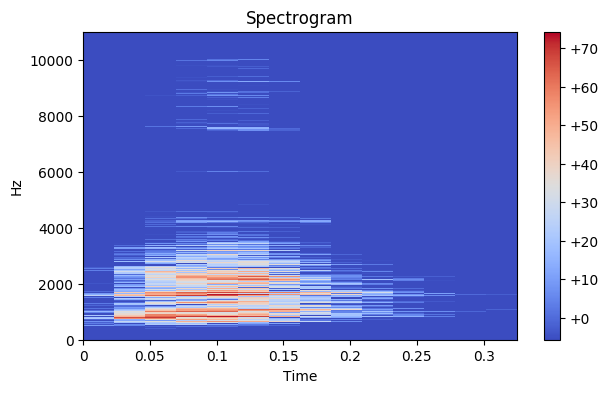

In [110]:
# convert stft feature from amplitude to decibel absolute value
spec = librosa.amplitude_to_db(abs(stft)**2)
plt.figure(figsize=(7, 4))
# display spectrogram using librosa specshow function
librosa.display.specshow(spec, sr=sample_rate, x_axis='time', y_axis='linear')
plt.title(label='Spectrogram')
plt.colorbar(format="%+2.f")
plt.show()

The log-amplitude is helpful, but to have a clear observation, we need to change the frequency axis into log as well.

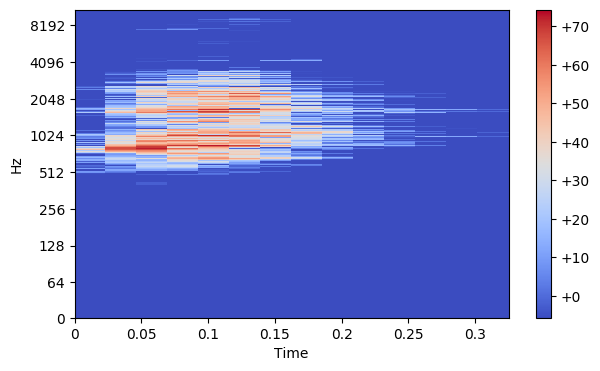

In [111]:
plt.figure(figsize=(7, 4))
librosa.display.specshow(spec, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format="%+2.f")
plt.show()


The spectrogram as shown above hold all the information that is necessary to understand an audio signal, its time, frequency and amplitude properties. We can simply use these information to train our models, but still this spectrogram is missing a very important detail. The humans perceive the change in frequency a bit differnetly than the one shown in these spectrograms. To overcome this perception issue, there is another type of spectogram that scales the frequency based on the pitch (melody) as perceived by humans. This type of spectogram is called a Mel-spectogram and it shows frequency in Mel-scale. Adding this feature in the plot makes it more desireable to be used for the training of ML/DL models.

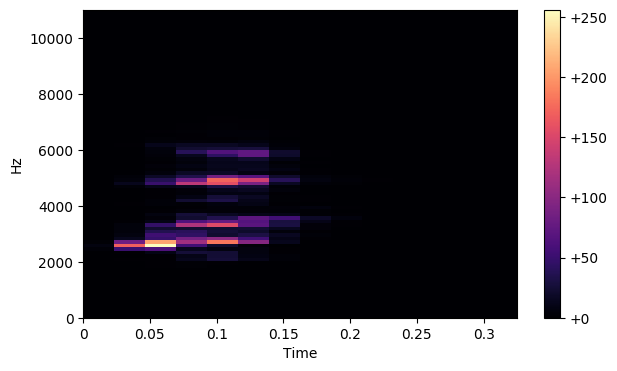

In [181]:
plt.figure(figsize=(7,4))
spectro = librosa.feature.melspectrogram(data,n_mels=90, sr=sample_rate)
librosa.display.specshow(spectro, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar(format="%+2.f")
plt.show()

In [124]:
np.shape(spectro)

(128, 14)

### MFCC

Mel-frequency cepstral coefficients (MFCCs) are a group of characteristics frequently utilised in music information retrieval and voice recognition. They are created by employing a filterbank to analyse a signal cepstrally, simulating the human auditory system's reaction to various frequencies. In order to convert frequencies to mel frequencies, which are perceptually more important, the filterbank often utilises a mel scale. The discrete cosine transform is then used to convert the resultant mel-frequency cepstrum to the frequency domain, producing a collection of MFCCs. In addition to MFCCs, we can also calculate the changes in the coeffecient values called delta-MFCCs and delta2-MFCCs. When performing tasks like voice or music identification, machine learning algorithms frequently employ these coefficients as features.

In [119]:
mfccs = librosa.feature.mfcc(y=data, n_mfcc=13, sr=sample_rate)
delta_mfccs = librosa.feature.delta(mfccs)
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

In [123]:
np.shape(mfccs)

(13, 14)

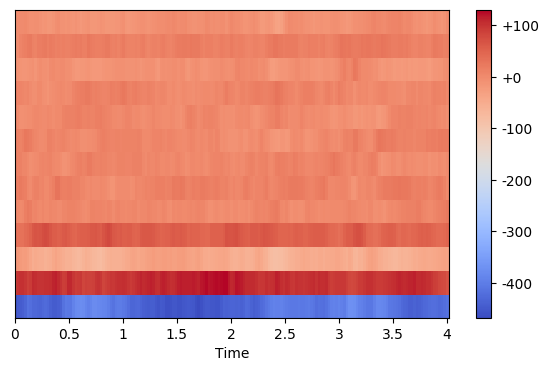

In [55]:
plt.figure(figsize=(7, 4))
librosa.display.specshow(mfccs, 
                         x_axis="time", 
                         sr=sample_rate)
plt.colorbar(format="%+2.f")
plt.show()

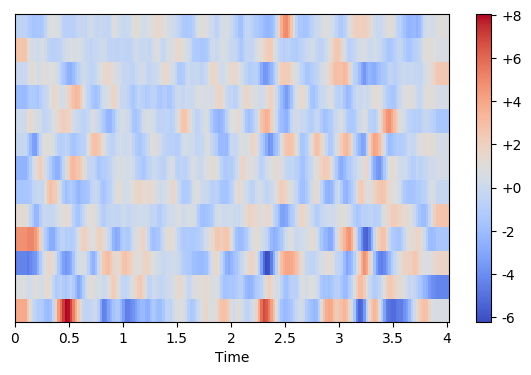

In [56]:
plt.figure(figsize=(7, 4))
librosa.display.specshow(delta_mfccs, 
                         x_axis="time", 
                         sr=sample_rate)
plt.colorbar(format="%+2.f")
plt.show()

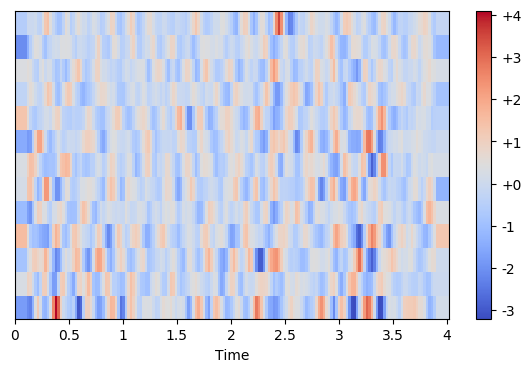

In [57]:
plt.figure(figsize=(7, 4))
librosa.display.specshow(delta2_mfccs, 
                         x_axis="time", 
                         sr=sample_rate)
plt.colorbar(format="%+2.f")
plt.show()

### Feature Extraction

Now that we have suffecient information about the features that we can use for our model, we need to extract these features and create a dataset so that we can train our model using these features.

In [198]:
    # list with spectrogram features
    melspec_list = []
    # list with mfcc features
    mfcc_list = []
    # list with d-mfcc features
    delta_mfcc_list = []   
    # list with d2-mfcc features
    delta2_mfcc_list = []      
    # list with concatenated features
    concat_list = []
    # label lists
    label_list = []

    for i in range(len(df)):
        # path of audio file
        file_path = './audio/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        # load audio file as numpy array
        audio_data, sample_rate = librosa.load(file_path)

        # extract mel spectrogram
        mel_spec = librosa.feature.melspectrogram(audio_data, sr=sample_rate, n_mels=10)
        #average column values of the spec array 
        mel_spec = np.mean(mel_spec, axis=1)
        # append spectrogram features to the list
        melspec_list.append(mel_spec)

        # extract mfccs
        mfcc = librosa.feature.mfcc(audio_data, n_mfcc=13, sr=sample_rate)
        delta_mfcc = librosa.feature.delta(mfcc,mode='wrap')
        delta2_mfcc = librosa.feature.delta(mfcc,mode='wrap', order=2)
        
        # average column values of the mfccs arrays
        mfcc = np.mean(mfcc, axis=1)
        delta_mfcc = np.mean(delta_mfcc, axis=1)
        delta2_mfcc = np.mean(delta2_mfcc, axis=1)
        # append mfcc features to the list
        mfcc_list.append(mfcc) 
        delta_mfcc_list.append(delta_mfcc)
        delta2_mfcc_list.append(delta2_mfcc)     
        

        # concatenate the features of spectrogram and mfcc
        new_features = np.concatenate((mel_spec, mfcc,delta_mfcc,delta2_mfcc), axis=0)
        # append combined features to the list
        concat_list.append(new_features)
    
        # append classID of the audio to the labels list
        label_list.append(df['classID'][i])


/home/msc1/Desktop/AML project/environmental_sound_classification/Sounds-Classification/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
/home/msc1/Desktop/AML project/environmental_sound_classification/Sounds-Classification/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
/home/msc1/Desktop/AML project/environmental_sound_classification/Sounds-Classification/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]


In the above code, we extracted 10 values of Mel-spectrogram and 13 values of each MFCCs, Delta-MFCCs and Delta2-MFCCS. We then concatenated these values togeter to make a dataset with 49 columns. To observe this datset we can create a pandas dataframe as shown below

In [221]:
ms = ["MS_" + str(i) for i in range(1,11)]
m = ["M_" + str(i) for i in range(1,14)]
dm = ["DM_" + str(i) for i in range(1,14)]
d2m = ["D2M_" + str(i) for i in range(1,14)]
col= ms+m+dm+d2m
Features=pd.DataFrame(concat_list,columns=col)
Features

,MS_1,MS_2,MS_3,MS_4,MS_5,MS_6,MS_7,MS_8,MS_9,MS_10,...,D2M_4,D2M_5,D2M_6,D2M_7,D2M_8,D2M_9,D2M_10,D2M_11,D2M_12,D2M_13
0,0.010397,4.885858,18.694080,6.911682,12.041814,4.978973,0.410840,0.025499,0.004605,0.010406,...,-3.405980e-08,-5.108970e-08,1.277242e-08,0.000000e+00,-1.702990e-08,-4.257475e-09,3.831727e-08,-8.514950e-09,0.000000e+00,2.554485e-08
1,0.005801,0.001472,0.001066,0.001412,0.003024,0.003003,0.001526,0.000404,0.000024,0.000006,...,-5.512568e-09,-1.378142e-09,2.067213e-09,4.134426e-09,-1.378142e-09,-6.890710e-10,7.579781e-09,2.756284e-09,-1.378142e-09,-1.378142e-09
2,0.004621,0.000699,0.001690,0.001814,0.000819,0.000533,0.000218,0.000107,0.000007,0.000001,...,-2.411749e-09,5.512568e-09,5.512568e-09,-3.617623e-09,4.134426e-09,-3.445355e-10,-8.613388e-10,6.890710e-10,4.134426e-09,4.823497e-09
3,0.012057,0.010407,0.002663,0.002736,0.003007,0.002959,0.001189,0.000780,0.000105,0.000020,...,-8.268852e-09,-8.268852e-09,-1.378142e-09,-2.756284e-09,0.000000e+00,5.512568e-09,2.756284e-09,-1.033607e-09,-9.646994e-09,1.378142e-09
4,0.004631,0.000641,0.000760,0.000799,0.001290,0.001352,0.000348,0.000193,0.000011,0.000002,...,-8.268852e-09,1.722678e-09,0.000000e+00,-1.378142e-08,-6.890710e-10,1.378142e-09,2.756284e-09,-3.789891e-09,1.033607e-09,-3.337688e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8727,0.011879,0.003191,0.010300,0.007516,0.002040,0.002335,0.000844,0.000106,0.000016,0.000003,...,1.550410e-09,3.789891e-09,-6.890710e-10,-2.067213e-09,-3.100820e-09,-1.722678e-09,2.756284e-09,-1.378142e-09,1.378142e-09,-2.756284e-09
8728,0.014177,0.011168,0.008087,0.002873,0.001358,0.011959,0.142112,0.057883,0.000225,0.000088,...,-1.249775e-08,-1.281820e-09,6.248874e-09,3.845461e-09,3.444892e-09,5.768191e-09,-3.845461e-09,-7.690922e-09,-3.204551e-09,4.165916e-09
8729,0.095023,0.041616,0.066104,0.036440,0.022224,0.025231,0.033332,0.010251,0.002109,0.000893,...,-2.368397e-09,1.578931e-09,-3.157862e-09,6.315724e-09,1.578931e-09,-7.105189e-09,3.157862e-09,6.315724e-09,-3.157862e-09,-7.894655e-10
8730,0.022105,0.025461,0.059470,0.013633,0.005987,0.003412,0.013770,0.003290,0.000044,0.000013,...,-4.374653e-09,6.691211e-10,-1.913911e-09,-1.367079e-09,-2.187326e-09,6.767041e-09,4.374653e-09,-3.007574e-09,1.093663e-09,1.148346e-08


In ML/DL models, it is sometimes important to see if a feature plays significant role in determining the classes. For this purpose we sometimes find the correlation between the features and drop highly correlated columns. But as shown by the below code, none of the features are highly correlated (85% is the industry standard for threshold). Thus we will not be dropping any columns.

In [264]:
def correlation(dataset, threshold):    
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]     # getting the name of column
                col_corr.add(colname)
    return col_corr

threshold=.85   # try 0.85 . 0.90 and 0.95 to see the number of features to be removed
corr_features = correlation(Features, threshold)
if (len(corr_features)) < 1:
       print('There are no features to remove.')
else:
    print(len(set(corr_features)),'features to remove are:',corr_features)

There are no features to remove.


In [268]:
Features.to_csv('/home/msc1/Desktop/ADL_project/environmental_sound_classification/CW2/Features.csv')

### Note:
##### ** Because of a library mismatch, the dataset was stored in form of a csv file, and then loaded again to complete the task in a different venv.**

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D,LSTM,Conv2D,MaxPooling1D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [2]:
Features=pd.read_csv('/home/msc1/Desktop/ADL_project/environmental_sound_classification/CW2/features.csv')

In [3]:
from sklearn.decomposition import PCA

# Create a PCA object with the number of components to retain 90% of information
pca = PCA(n_components=0.9)

# Apply PCA to the data
pca.fit(Features.drop('classID',axis=1))

# Transform the data into principal components
pca_data = pca.transform(Features.drop('classID',axis=1))

# Create a new DataFrame with the principal components
pca_Features = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Print the explained variance ratio for each principal component
print('Explained variance ratio:', pca.explained_variance_ratio_)

Explained variance ratio: [0.76243137 0.09834598 0.05206953]


In [4]:
pca_Features

,PC1,PC2,PC3
0,-23.080488,39.332249,122.827574
1,189.516705,24.679216,9.401873
2,226.328752,16.228285,7.489724
3,179.622866,32.190079,-2.582220
4,212.682644,22.378837,7.986888
...,...,...,...
8727,167.898659,-2.981466,17.702776
8728,109.845400,39.282410,17.135437
8729,71.839620,10.474502,12.436722
8730,112.447926,0.726008,24.130414


The Explained varience ratio shows that the first Principal Component contains 76.24% of information from the original dataset. The second components contains an additional 9.83% of information and the third component contains an additional 5.2% making the total information in the PCs to be a little over 90%. 

We will convert dependent and independent columns into numpyarray to be used by keras. We will also convert PCA components into numpy array. We will try to train our model with all the features and also the dimentionality reduced features to see how much differnce in the performance can be seen when PCA is applied to the dataset.

In [5]:
concat_array = np.array(Features.drop('classID',axis=1))
pca_array = np.array(pca_Features)
label_array = np.array(Features['classID'])

To convert the class ids into one-hot encoded labels, we can use the to_categorical function from keras.

In [6]:
from tensorflow.keras.utils import to_categorical

In [7]:
label_array = to_categorical(label_array)
label_array.shape

(8732, 10)

### Train-Test-Validation Split

Afyer the feature extraction and Dimentionalaity reduction using PCA we need to divide the data into three subsets. 
1. Train set
2. Test set
3. Validation set

**Train set:** The train set will have 81% of data.
**Test set:** The test set will have 10% of data.
**Validation set:** The validation set will have 9% of data.

We divide the original dataset into three subsets as we do not want to test or validate the model performance on the same data it is trained on.

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X, X_test, y, y_test = train_test_split(concat_array, label_array, test_size=0.1, random_state=12, stratify=label_array)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [11]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(7072, 49) (7072, 10)
(786, 49) (786, 10)
(874, 49) (874, 10)


In [12]:
counts = np.sum(y_train, axis=0)

# Print the counts of each number
for i in range(len(counts)):
    print(f"Number {i} appears {counts[i]} times in the array.")

Number 0 appears 810.0 times in the array.
Number 1 appears 347.0 times in the array.
Number 2 appears 810.0 times in the array.
Number 3 appears 810.0 times in the array.
Number 4 appears 810.0 times in the array.
Number 5 appears 810.0 times in the array.
Number 6 appears 303.0 times in the array.
Number 7 appears 810.0 times in the array.
Number 8 appears 752.0 times in the array.
Number 9 appears 810.0 times in the array.


Although there are two classes that have a little lesser number of instances than the other classes, but they are enough to give decent results. In case the model performs poorly, we can use SMOTE to balance the dataset by adding more instances. 

## Model Training

### ANNs

Artificial Neural Networks (ANNs) are a type of machine learning model inspired by biological neurons in the brain. ANNs consist of multiple layers of interconnected artificial neurons that process and transmit information. The input data is fed into the input layer, which passes the information to the hidden layers through weighted connections between neurons. The weights between neurons in the network are learned during the training process by adjusting them to minimize a loss function using backpropagation.

#### Training with all the features

In [13]:
input_shape = X_train.shape[1:]

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Activation,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

### A basic ANN

The first model that we are going to train on all the features we extracted would be an ANN with increasing number of neurons in subsequent layers. the neurons in the first layer are kept double than the number of inputs. lesser number of neurons in the initial layers will help the model to learn on low level features of the dataset. The complexity is increased gradually so that the model can learn high level features as well. The output layer has 10 neurons, as we have 10 classes.

In [15]:
modelANN = Sequential()

# We are adding 20% dropout in each dense layer
modelANN.add(Dense(100,input_shape=input_shape))
modelANN.add(Activation("relu"))
modelANN.add(Dropout(0.2))

modelANN.add(Dense(300))
modelANN.add(Activation("relu"))
modelANN.add(Dropout(0.2))

modelANN.add(Dense(300))
modelANN.add(Activation("relu"))
modelANN.add(Dropout(0.2))

modelANN.add(Dense(100))
modelANN.add(Activation("relu"))
modelANN.add(Dropout(0.2))

# The output layer will have 10 neurons as out classifier gives 10bit result         
modelANN.add(Dense(10))
modelANN.add(Activation("softmax"))

# Show summary of the model
modelANN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               5000      
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               30300     
_________________________________________________________________
activation_3 (Activation)    (None, 300)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)              

To compile the model we will be using a categorical cross entropy loss as it is used when the output is in the categorical form. The optimizer that we use will be adam and the performance metrics will be set to accuracy.

In [16]:
modelANN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

For this model we will be using the following hyper parameters
1. epochs:  This parameter will specify for how many iterations the training process will run.During each epoch, the model processes the entire training dataset, updates the model's weights, and evaluates the model's performance on the training data.
2. batch size: This parameter specifies the number of samples that the neural network processes before updating the model's weights during training.
3. monitor: This parameter specifies which metric to monitor during training. In this case, the validation loss is being monitored, so the value of monitor is set to 'val_loss'.
4. mode: This parameter specifies whether to minimize or maximize the monitored metric. In this case, we want to minimize the validation loss, so the value of mode is set to 'min'.
5. verbose: This parameter controls the verbosity of the output during training. A value of 1 means that progress messages will be displayed on the console.
6. patience: This parameter specifies how many epochs to wait before stopping the training process if the monitored metric does not improve. In this case, the training will stop if the validation loss does not improve after 25 epochs.

In [17]:
epochs = 100
batch_size = 32
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

In [18]:
historyANN = modelANN.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stop]
)

Epoch 1/100


2023-04-07 20:31:31.372605: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


221/221 [==============================] - 0s 2ms/step - loss: 3.3175 - accuracy: 0.1516 - val_loss: 2.2132 - val_accuracy: 0.1947
Epoch 2/100
221/221 [==============================] - 0s 2ms/step - loss: 2.1189 - accuracy: 0.2407 - val_loss: 1.8499 - val_accuracy: 0.4109
Epoch 3/100
221/221 [==============================] - 0s 1ms/step - loss: 1.9049 - accuracy: 0.3258 - val_loss: 1.6265 - val_accuracy: 0.4644
Epoch 4/100
221/221 [==============================] - 0s 2ms/step - loss: 1.7574 - accuracy: 0.3791 - val_loss: 1.4591 - val_accuracy: 0.4936
Epoch 5/100
221/221 [==============================] - 0s 1ms/step - loss: 1.6161 - accuracy: 0.4314 - val_loss: 1.3781 - val_accuracy: 0.5204
Epoch 6/100
221/221 [==============================] - 0s 2ms/step - loss: 1.5193 - accuracy: 0.4688 - val_loss: 1.2525 - val_accuracy: 0.5891
Epoch 7/100
221/221 [==============================] - 0s 2ms/step - loss: 1.4243 - accuracy: 0.5049 - val_loss: 1.1762 - val_accuracy: 0.6107
Epoch 8/100

221/221 [==============================] - 0s 1ms/step - loss: 0.4634 - accuracy: 0.8443 - val_loss: 0.4192 - val_accuracy: 0.8626
Epoch 59/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4810 - accuracy: 0.8394 - val_loss: 0.3802 - val_accuracy: 0.8753
Epoch 60/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4502 - accuracy: 0.8512 - val_loss: 0.3999 - val_accuracy: 0.8753
Epoch 61/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4621 - accuracy: 0.8450 - val_loss: 0.3719 - val_accuracy: 0.8868
Epoch 62/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4616 - accuracy: 0.8398 - val_loss: 0.3757 - val_accuracy: 0.8791
Epoch 63/100
221/221 [==============================] - 0s 2ms/step - loss: 0.4527 - accuracy: 0.8481 - val_loss: 0.4033 - val_accuracy: 0.8753
Epoch 64/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4481 - accuracy: 0.8528 - val_loss: 0.3793 - val_accuracy: 0.8715
Epoch

In [19]:
score = modelANN.evaluate(X_test, y_test)
print('\nThe model test accuracy is',score[1]*100 ,'\n\nThe model test loss is',score[0]*100)

28/28 [==============================] - 0s 731us/step - loss: 0.3822 - accuracy: 0.8890

The model test accuracy is 88.90160322189331 

The model test loss is 38.22210133075714


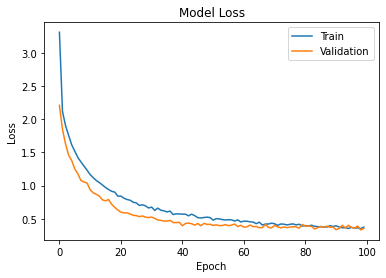

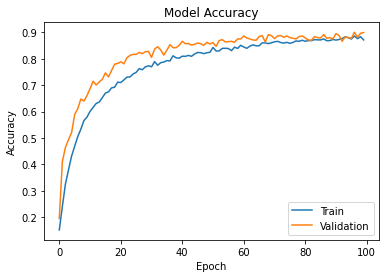

In [20]:
import matplotlib.pyplot as plt

# Plot the convergence graph for loss
plt.plot(historyANN.history['loss'])
plt.plot(historyANN.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot the convergence graph for accuracy
plt.plot(historyANN.history['accuracy'])
plt.plot(historyANN.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [23]:
from sklearn.metrics import classification_report,confusion_matrix
pred = modelANN.predict(X_test)
# one hot encoded multiclass labels so converting to argmax
arg_pred = np.argmax(pred, axis=1)
arg_true = np.argmax(y_test, axis=1)
print(confusion_matrix(arg_true, arg_pred))

[[97  0  2  0  0  0  0  0  0  1]
 [ 1 32  0  0  1  2  1  1  2  3]
 [ 4  1 86  2  2  1  0  0  1  3]
 [ 1  0  4 79  0  1  5  0  5  5]
 [ 0  0  3  0 91  0  1  3  2  0]
 [ 0  0  3  0  0 97  0  0  0  0]
 [ 1  0  2  0  1  0 34  0  0  0]
 [ 1  1  0  0  2  1  0 93  0  2]
 [ 0  0  2  0  0  0  0  0 90  1]
 [ 3  1 16  0  0  0  1  1  0 78]]


In [24]:
print(classification_report(arg_true, arg_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       100
           1       0.91      0.74      0.82        43
           2       0.73      0.86      0.79       100
           3       0.98      0.79      0.87       100
           4       0.94      0.91      0.92       100
           5       0.95      0.97      0.96       100
           6       0.81      0.89      0.85        38
           7       0.95      0.93      0.94       100
           8       0.90      0.97      0.93        93
           9       0.84      0.78      0.81       100

    accuracy                           0.89       874
   macro avg       0.89      0.88      0.88       874
weighted avg       0.89      0.89      0.89       874



In [21]:
modelANN.save('ann_1.h5')

#### Model 2 - Newral Network Pruning:

In the second model, we are going to try a very effective technique called 'Neural Network Pruning' where we start at a higer number of neurons in the first layer and gradually decrease the neurons in the comming layers. In this model we will start at 500 neurons in the input layer and start to decrease the neurons by 100 in every next layer. We have added a 30% dropout before the output layer sa well.

In [41]:
model2 = Sequential()
model2.add(Dense(500, activation='relu', input_shape=input_shape))
model2.add(Dense(400, activation='relu'))
model2.add(Dense(300, activation='relu'))
model2.add(Dense(200, activation='relu'))
model2.add(Dense(100, activation='relu'))
# drop 30% neurons
model2.add(Dropout(0.3))
# output layer
model2.add(Dense(10, activation='softmax'))
# check model summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               25000     
_________________________________________________________________
dense_1 (Dense)              (None, 400)               200400    
_________________________________________________________________
dense_2 (Dense)              (None, 300)               120300    
_________________________________________________________________
dense_3 (Dense)              (None, 200)               60200     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [42]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
epochs = 100
batch_size = 32
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [44]:
history2 = model2.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stop]
)

Epoch 1/100
221/221 [==============================] - 1s 2ms/step - loss: 1.9760 - accuracy: 0.3512 - val_loss: 1.4351 - val_accuracy: 0.5064
Epoch 2/100
221/221 [==============================] - 0s 2ms/step - loss: 1.4706 - accuracy: 0.4901 - val_loss: 1.2118 - val_accuracy: 0.5878
Epoch 3/100
221/221 [==============================] - 0s 2ms/step - loss: 1.2568 - accuracy: 0.5771 - val_loss: 1.0334 - val_accuracy: 0.6374
Epoch 4/100
221/221 [==============================] - 0s 2ms/step - loss: 1.1094 - accuracy: 0.6208 - val_loss: 0.9450 - val_accuracy: 0.6743
Epoch 5/100
221/221 [==============================] - 0s 1ms/step - loss: 0.9859 - accuracy: 0.6745 - val_loss: 0.8972 - val_accuracy: 0.6934
Epoch 6/100
221/221 [==============================] - 0s 2ms/step - loss: 0.8831 - accuracy: 0.7083 - val_loss: 0.8102 - val_accuracy: 0.7176
Epoch 7/100
221/221 [==============================] - 0s 2ms/step - loss: 0.7930 - accuracy: 0.7320 - val_loss: 0.6550 - val_accuracy: 0.7735

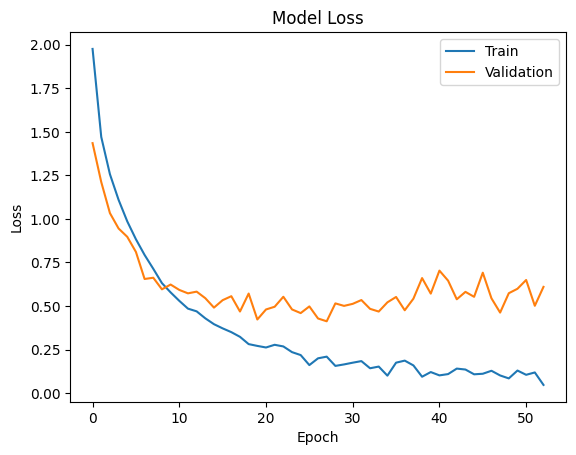

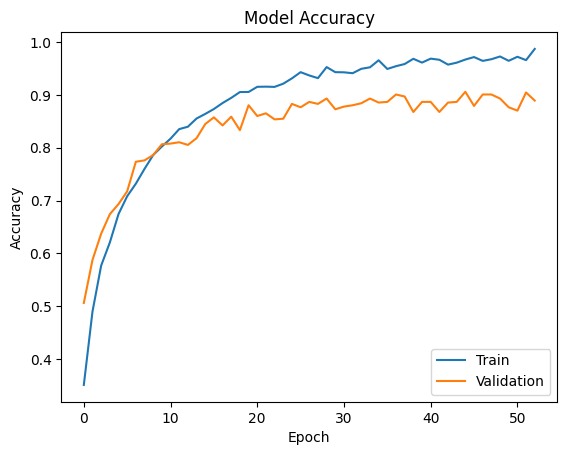

In [45]:
import matplotlib.pyplot as plt
# Plot the convergence graph for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot the convergence graph for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [46]:
from sklearn.metrics import classification_report,confusion_matrix
pred = model2.predict(X_test)
# one hot encoded multiclass labels so converting to argmax
arg_pred = np.argmax(pred, axis=1)
arg_true = np.argmax(y_test, axis=1)
print(confusion_matrix(arg_true, arg_pred))

[[97  0  0  1  0  0  0  0  0  2]
 [ 1 32  1  1  0  0  1  0  1  6]
 [ 3  0 79 10  3  0  0  1  0  4]
 [ 2  2  6 84  0  0  2  0  2  2]
 [ 0  3  1  1 90  0  0  3  1  1]
 [ 0  3  1  0  0 94  1  0  0  1]
 [ 0  0  0  3  0  0 35  0  0  0]
 [ 0  1  1  0  3  1  0 94  0  0]
 [ 0  1  1  0  0  0  0  0 90  1]
 [ 2  1  3  1  3  0  0  0  0 90]]


In [47]:
print(classification_report(arg_true, arg_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       100
           1       0.74      0.74      0.74        43
           2       0.85      0.79      0.82       100
           3       0.83      0.84      0.84       100
           4       0.91      0.90      0.90       100
           5       0.99      0.94      0.96       100
           6       0.90      0.92      0.91        38
           7       0.96      0.94      0.95       100
           8       0.96      0.97      0.96        93
           9       0.84      0.90      0.87       100

    accuracy                           0.90       874
   macro avg       0.89      0.89      0.89       874
weighted avg       0.90      0.90      0.90       874



In [48]:
model2.save('ann_nnp.h5')

#### Model- 3: Hyperparameter tunning 

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

In [31]:
def build_model(hp):
    model = keras.Sequential()
    # Input layer
    model.add(layers.Dense(units=hp.Int('units_input', min_value=100, max_value=500, step=16), input_dim=49, activation='relu'))
    # Hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=100, max_value=500, step=16), activation='relu'))
    # Output layer
    model.add(layers.Dense(units=10, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [32]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='Tuning',
    project_name='SoundClassification')


In [51]:
history_tuned = tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val))


INFO:tensorflow:Oracle triggered exit


In [54]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


In [55]:
tuner.results_summary()

Results summary
Results in Tuning/SoundClassification
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 08 summary
Hyperparameters:
units_input: 452
num_layers: 2
units_0: 436
learning_rate: 0.001
units_1: 404
units_2: 212
units_3: 356
Score: 0.9189991354942322

Trial 07 summary
Hyperparameters:
units_input: 148
num_layers: 4
units_0: 116
learning_rate: 0.001
units_1: 292
units_2: 452
units_3: 292
Score: 0.9156064391136169

Trial 00 summary
Hyperparameters:
units_input: 468
num_layers: 2
units_0: 292
learning_rate: 0.001
units_1: 100
Score: 0.9139100909233093

Trial 03 summary
Hyperparameters:
units_input: 484
num_layers: 4
units_0: 452
learning_rate: 0.001
units_1: 196
units_2: 484
units_3: 228
Score: 0.9122137427330017

Trial 01 summary
Hyperparameters:
units_input: 276
num_layers: 4
units_0: 340
learning_rate: 0.001
units_1: 164
units_2: 100
units_3: 100
Score: 0.9113655686378479

Trial 05 summary
Hyperparameters:
units_input: 420
num_layers: 2
units_0: 2

In [56]:
model = tuner.hypermodel.build(best_hps)

In [57]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 452)               22600     
_________________________________________________________________
dense_8 (Dense)              (None, 436)               197508    
_________________________________________________________________
dense_9 (Dense)              (None, 404)               176548    
_________________________________________________________________
dense_10 (Dense)             (None, 10)                4050      
Total params: 400,706
Trainable params: 400,706
Non-trainable params: 0
_________________________________________________________________


In [59]:
from tensorflow.keras import optimizers

model.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(lr=0.001), metrics=['accuracy'])


In [60]:
history=model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
221/221 [==============================] - 0s 1ms/step - loss: 2.4650 - accuracy: 0.4460 - val_loss: 1.4116 - val_accuracy: 0.5331
Epoch 2/100
221/221 [==============================] - 0s 1ms/step - loss: 1.2151 - accuracy: 0.5875 - val_loss: 1.1000 - val_accuracy: 0.6247
Epoch 3/100
221/221 [==============================] - 0s 1ms/step - loss: 1.0571 - accuracy: 0.6349 - val_loss: 0.9255 - val_accuracy: 0.6870
Epoch 4/100
221/221 [==============================] - 0s 1ms/step - loss: 0.9000 - accuracy: 0.6949 - val_loss: 0.8304 - val_accuracy: 0.7087
Epoch 5/100
221/221 [==============================] - 0s 1ms/step - loss: 0.7792 - accuracy: 0.7380 - val_loss: 0.7019 - val_accuracy: 0.7710
Epoch 6/100
221/221 [==============================] - 0s 1ms/step - loss: 0.6684 - accuracy: 0.7714 - val_loss: 0.7163 - val_accuracy: 0.7481
Epoch 7/100
221/221 [==============================] - 0s 1ms/step - loss: 0.5981 - accuracy: 0.7940 - val_loss: 0.6323 - val_accuracy: 0.7977

Epoch 58/100
221/221 [==============================] - 0s 1ms/step - loss: 0.0413 - accuracy: 0.9876 - val_loss: 0.8845 - val_accuracy: 0.8715
Epoch 59/100
221/221 [==============================] - 0s 1ms/step - loss: 0.0958 - accuracy: 0.9726 - val_loss: 0.7195 - val_accuracy: 0.8817
Epoch 60/100
221/221 [==============================] - 0s 1ms/step - loss: 0.1133 - accuracy: 0.9659 - val_loss: 0.7044 - val_accuracy: 0.8842
Epoch 61/100
221/221 [==============================] - 0s 1ms/step - loss: 0.1023 - accuracy: 0.9717 - val_loss: 0.7270 - val_accuracy: 0.9020
Epoch 62/100
221/221 [==============================] - 0s 1ms/step - loss: 0.0645 - accuracy: 0.9816 - val_loss: 0.8354 - val_accuracy: 0.8779
Epoch 63/100
221/221 [==============================] - 0s 1ms/step - loss: 0.0716 - accuracy: 0.9794 - val_loss: 0.6862 - val_accuracy: 0.8957
Epoch 64/100
221/221 [==============================] - 0s 1ms/step - loss: 0.0722 - accuracy: 0.9809 - val_loss: 0.8478 - val_accuracy:

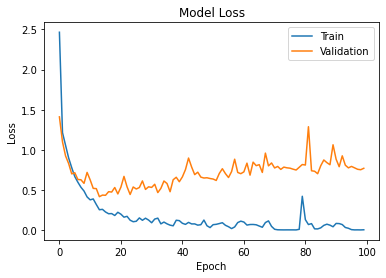

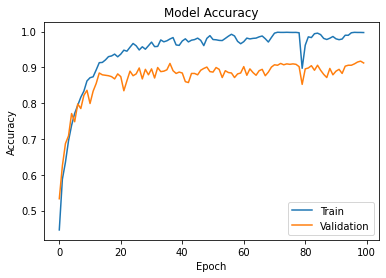

In [61]:
import matplotlib.pyplot as plt

# Plot the convergence graph for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot the convergence graph for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [62]:
from sklearn.metrics import classification_report,confusion_matrix
pred = model.predict(X_test)
# one hot encoded multiclass labels so converting to argmax
arg_pred = np.argmax(pred, axis=1)
arg_true = np.argmax(y_test, axis=1)
print(confusion_matrix(arg_true, arg_pred))

[[97  0  2  1  0  0  0  0  0  0]
 [ 1 33  0  0  0  0  2  2  2  3]
 [ 0  1 88  0  1  1  0  1  3  5]
 [ 1  2  8 82  2  0  2  0  3  0]
 [ 0  0  0  0 94  0  0  3  3  0]
 [ 0  0  0  1  0 98  0  0  0  1]
 [ 1  0  0  1  1  0 35  0  0  0]
 [ 0  1  0  0  3  0  0 96  0  0]
 [ 0  0  1  0  0  0  0  0 89  3]
 [ 2  0  2  1  1  0  0  1  1 92]]


In [63]:
print(classification_report(arg_true, arg_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       100
           1       0.89      0.77      0.82        43
           2       0.87      0.88      0.88       100
           3       0.95      0.82      0.88       100
           4       0.92      0.94      0.93       100
           5       0.99      0.98      0.98       100
           6       0.90      0.92      0.91        38
           7       0.93      0.96      0.95       100
           8       0.88      0.96      0.92        93
           9       0.88      0.92      0.90       100

    accuracy                           0.92       874
   macro avg       0.92      0.91      0.91       874
weighted avg       0.92      0.92      0.92       874



In [64]:
model.save('ann_tuned.h5')

#### Model using PCA components

Now lets train our model on the pca components that we created earlier. Although 90% of information is available in the 3 pca we can not expect the model to perform very well as using pca usually reduces the performance of the model. 

In [10]:
X, X_test, y, y_test = train_test_split(pca_array, label_array, test_size=0.1, random_state=42, stratify=label_array)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(7072, 3) (7072, 10)
(786, 3) (786, 10)
(874, 3) (874, 10)


We will go straight into using the random search method to find out how it performs on various ANN models. At the end we can see the results and compare to our intial hypothesis.

In [11]:
def build_model(hp):
    model = keras.Sequential()
    # Input layer
    model.add(layers.Dense(units=hp.Int('units_input', min_value=100, max_value=500, step=16), input_dim=3, activation='relu'))
    # Hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=100, max_value=500, step=16), activation='relu'))
    # Output layer
    model.add(layers.Dense(units=10, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


Same as before, we will be doing 10 trails with 100 epocs to have an idea how the model performs.

In [14]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='pca',
    project_name='SoundClassification')


2023-04-08 01:03:01.064217: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-04-08 01:03:01.089491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-08 01:03:01.089944: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.755GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2023-04-08 01:03:01.090055: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-04-08 01:03:01.090851: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-08 01:03:01.091622: I tensorflow/stream_executor/pl

In [15]:
history_tuned = tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val))


Trial 10 Complete [00h 01m 08s]
val_accuracy: 0.5313825209935507

Best val_accuracy So Far: 0.5606446266174316
Total elapsed time: 00h 14m 39s
INFO:tensorflow:Oracle triggered exit


So we can see that none of the 10 trials gave much promising results.Even if we train the best model for a 100 more epocs the validation loss seems to increase and the validation accuracy does notincrease more than 50-55 percent. This is all observable in the graphs below. This is because the data required to train the model is not enough for it to learn all the features and it starts to over fit to the training instances rather than generalizing. That is why it starts to give good accuracy and loss after some time on training data but not on the validation data. If we test the model on test data we come to see that the metrics are extreamely poor as compared to the model that is trained on the complete dataset.

In [16]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


In [17]:
tuner.results_summary()

Results summary
Results in pca/SoundClassification
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
units_input: 244
num_layers: 4
units_0: 212
learning_rate: 0.001
units_1: 436
units_2: 260
units_3: 100
Score: 0.5606446266174316

Trial 02 summary
Hyperparameters:
units_input: 148
num_layers: 3
units_0: 132
learning_rate: 0.001
units_1: 228
units_2: 388
Score: 0.558948278427124

Trial 04 summary
Hyperparameters:
units_input: 308
num_layers: 2
units_0: 292
learning_rate: 0.001
units_1: 148
units_2: 132
Score: 0.5491942365964254

Trial 07 summary
Hyperparameters:
units_input: 116
num_layers: 4
units_0: 292
learning_rate: 0.0001
units_1: 468
units_2: 324
units_3: 356
units_4: 212
Score: 0.5351993242899576

Trial 09 summary
Hyperparameters:
units_input: 484
num_layers: 1
units_0: 260
learning_rate: 0.001
units_1: 244
units_2: 452
units_3: 436
units_4: 388
Score: 0.5313825209935507

Trial 08 summary
Hyperparameters:
units_input: 308
n

In [18]:
model_pca = tuner.hypermodel.build(best_hps)

In [19]:
model_pca.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 244)               976       
_________________________________________________________________
dense_4 (Dense)              (None, 212)               51940     
_________________________________________________________________
dense_5 (Dense)              (None, 436)               92868     
_________________________________________________________________
dense_6 (Dense)              (None, 260)               113620    
_________________________________________________________________
dense_7 (Dense)              (None, 100)               26100     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1010      
Total params: 286,514
Trainable params: 286,514
Non-trainable params: 0
________________________________________________

In [21]:
from tensorflow.keras import optimizers

model_pca.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(lr=0.001), metrics=['accuracy'])


In [22]:
history_pca=model_pca.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val))

Epoch 1/200
221/221 [==============================] - 0s 2ms/step - loss: 1.9296 - accuracy: 0.3050 - val_loss: 1.7663 - val_accuracy: 0.3677
Epoch 2/200
221/221 [==============================] - 0s 1ms/step - loss: 1.7334 - accuracy: 0.3539 - val_loss: 1.7488 - val_accuracy: 0.3728
Epoch 3/200
221/221 [==============================] - 0s 1ms/step - loss: 1.6959 - accuracy: 0.3644 - val_loss: 1.7159 - val_accuracy: 0.3957
Epoch 4/200
221/221 [==============================] - 0s 1ms/step - loss: 1.6706 - accuracy: 0.3760 - val_loss: 1.7074 - val_accuracy: 0.3880
Epoch 5/200
221/221 [==============================] - 0s 1ms/step - loss: 1.6388 - accuracy: 0.3999 - val_loss: 1.6600 - val_accuracy: 0.4059
Epoch 6/200
221/221 [==============================] - 0s 1ms/step - loss: 1.6087 - accuracy: 0.4033 - val_loss: 1.6443 - val_accuracy: 0.4071
Epoch 7/200
221/221 [==============================] - 0s 1ms/step - loss: 1.5811 - accuracy: 0.4053 - val_loss: 1.7026 - val_accuracy: 0.3804

Epoch 58/200
221/221 [==============================] - 0s 1ms/step - loss: 0.9544 - accuracy: 0.6382 - val_loss: 1.5259 - val_accuracy: 0.5127
Epoch 59/200
221/221 [==============================] - 0s 1ms/step - loss: 0.9414 - accuracy: 0.6370 - val_loss: 1.4336 - val_accuracy: 0.5293
Epoch 60/200
221/221 [==============================] - 0s 1ms/step - loss: 0.9231 - accuracy: 0.6408 - val_loss: 1.4911 - val_accuracy: 0.5407
Epoch 61/200
221/221 [==============================] - 0s 1ms/step - loss: 0.9323 - accuracy: 0.6456 - val_loss: 1.4910 - val_accuracy: 0.5204
Epoch 62/200
221/221 [==============================] - 0s 1ms/step - loss: 0.9242 - accuracy: 0.6425 - val_loss: 1.5304 - val_accuracy: 0.5076
Epoch 63/200
221/221 [==============================] - 0s 1ms/step - loss: 0.9076 - accuracy: 0.6505 - val_loss: 1.5972 - val_accuracy: 0.4936
Epoch 64/200
221/221 [==============================] - 0s 1ms/step - loss: 0.9069 - accuracy: 0.6486 - val_loss: 1.5176 - val_accuracy:

Epoch 115/200
221/221 [==============================] - 0s 1ms/step - loss: 0.6363 - accuracy: 0.7525 - val_loss: 2.1105 - val_accuracy: 0.5102
Epoch 116/200
221/221 [==============================] - 0s 1ms/step - loss: 0.6162 - accuracy: 0.7537 - val_loss: 1.9634 - val_accuracy: 0.5165
Epoch 117/200
221/221 [==============================] - 0s 1ms/step - loss: 0.5977 - accuracy: 0.7622 - val_loss: 2.0839 - val_accuracy: 0.5280
Epoch 118/200
221/221 [==============================] - 0s 1ms/step - loss: 0.6236 - accuracy: 0.7451 - val_loss: 2.0956 - val_accuracy: 0.5394
Epoch 119/200
221/221 [==============================] - 0s 1ms/step - loss: 0.6184 - accuracy: 0.7606 - val_loss: 2.0253 - val_accuracy: 0.5204
Epoch 120/200
221/221 [==============================] - 0s 1ms/step - loss: 0.6063 - accuracy: 0.7574 - val_loss: 2.1149 - val_accuracy: 0.5204
Epoch 121/200
221/221 [==============================] - 0s 1ms/step - loss: 0.5845 - accuracy: 0.7654 - val_loss: 2.0248 - val_ac

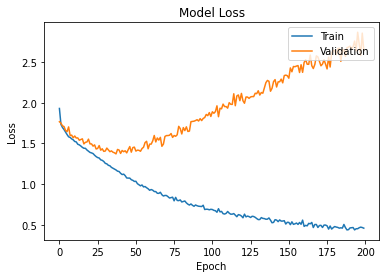

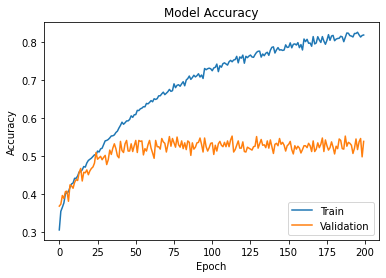

In [23]:
import matplotlib.pyplot as plt

# Plot the convergence graph for loss
plt.plot(history_pca.history['loss'])
plt.plot(history_pca.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot the convergence graph for accuracy
plt.plot(history_pca.history['accuracy'])
plt.plot(history_pca.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [24]:
from sklearn.metrics import classification_report,confusion_matrix
pred = model_pca.predict(X_test)
# one hot encoded multiclass labels so converting to argmax
arg_pred = np.argmax(pred, axis=1)
arg_true = np.argmax(y_test, axis=1)
print(confusion_matrix(arg_true, arg_pred))

[[79  2  3  1  2  3  1  3  0  6]
 [ 4 20  2  4  3  1  1  3  0  5]
 [ 3  7 47 14  1  2  4  2  9 11]
 [ 4  1 17 44  3  5  0  3 14  9]
 [ 3  2  2  4 62  2  2 12  3  8]
 [ 3  2  3  2  1 82  0  0  1  6]
 [ 0  0  2  7  1  1 20  1  4  2]
 [ 5  3  2  0  6  5  2 72  1  4]
 [ 1  4  4 13  0  2  1  4 56  8]
 [ 7  9 12  8  6  4  2  9 11 32]]


In [25]:
print(classification_report(arg_true, arg_pred))

              precision    recall  f1-score   support

           0       0.72      0.79      0.76       100
           1       0.40      0.47      0.43        43
           2       0.50      0.47      0.48       100
           3       0.45      0.44      0.45       100
           4       0.73      0.62      0.67       100
           5       0.77      0.82      0.79       100
           6       0.61      0.53      0.56        38
           7       0.66      0.72      0.69       100
           8       0.57      0.60      0.58        93
           9       0.35      0.32      0.34       100

    accuracy                           0.59       874
   macro avg       0.58      0.58      0.58       874
weighted avg       0.59      0.59      0.59       874



## Evaluation

We have trained 3 ANN models with diffrent parameters and one model trained with PCA components. We need to evaluate our models properly so that the performance does not drop when the model is deployed in the real word enviornment. To evaluate the models we can use the confusion matrix that we created for each model in the previous section. Using the confusuin matrix, we have already observed the classification report. The Classification report shows the precision, recall and f1 score of individual classes as well as averages to these values. The report also shows the average accuracy of the model. Although the classification report does not show the sensitivity and specificity of the model, we can calculate these using the confusion matrix. We can also create ROC AUC curves for the models to see at what threshold value we can get the best result for all the classes. 

We have saved all the models, and we can run the models individually to create a confusion matrix again to find the remaining evaluation criteria.

In [14]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np

Lets create a fuction that we can use to calculate the Avg. specificity, specificity per class and Avg. loss of the models. For this we will use the formulae of these quantities using true possitives, false possitives, true negatives and false negatives.

In [15]:
def specificity (conf_matrix):
    Spec_per_class=[]
    loss=0
    Los=[]
    Specificity=0
    dia=np.sum(np.diag(conf_matrix))
    for i in range(10):
        TP = conf_matrix[i][i]         # True Possitives
        sum=0
        for j in range(10):
            sum=sum+conf_matrix[j][i]   
        FP = sum-TP                    # False Possitives
        TN = dia-TP                    # True Negatives
        FN = np.sum(conf_matrix[i])-TP # False Negatives
        spec=TN/(TN+FP)                # Specificity
        Specificity=spec+Specificity
        Spec_per_class.append(spec)
        loss=(FP+FN)/(FP+FN+TP+TN)     # Also calculated loss
        Los.append(loss)    
    Loss=np.sum(Los)/10
    Avg_Specificity = Specificity/10    # Taking average value
    classes=['air_conditioner', 'car_horn','children_playing',
           'dog_bark','drilling','engine_idling','gun_shot',
           'jackhammer', 'siren', 'street_music']
    Spec_per_class=pd.DataFrame(data=Spec_per_class,index=classes,columns=['Specificity'])
    
    
    return(Avg_Specificity,Spec_per_class,Loss)

we will now load the first model again to evaluate it first.

### model-1

In [16]:
model_1 = load_model('ann_1.h5')

In [17]:
classes = ['air_conditioner', 'car_horn','children_playing',
           'dog_bark','drilling','engine_idling','gun_shot',
           'jackhammer', 'siren', 'street_music']

In [18]:
pred_1 = np.argmax(model_1.predict(X_test),axis=1)
true = np.argmax(y_test, axis=1)
cf_matrix_1 = confusion_matrix(true, pred_1)
print(cf_matrix_1)

[[97  0  2  0  0  0  0  0  0  1]
 [ 1 32  0  0  1  2  1  1  2  3]
 [ 4  1 86  2  2  1  0  0  1  3]
 [ 1  0  4 79  0  1  5  0  5  5]
 [ 0  0  3  0 91  0  1  3  2  0]
 [ 0  0  3  0  0 97  0  0  0  0]
 [ 1  0  2  0  1  0 34  0  0  0]
 [ 1  1  0  0  2  1  0 93  0  2]
 [ 0  0  2  0  0  0  0  0 90  1]
 [ 3  1 16  0  0  0  1  1  0 78]]


The confusuion matrix shows the number of true possitives, false positives, true negatives and false negatives.

In [19]:
print(classification_report(true, pred_1,target_names=classes))

                  precision    recall  f1-score   support

 air_conditioner       0.90      0.97      0.93       100
        car_horn       0.91      0.74      0.82        43
children_playing       0.73      0.86      0.79       100
        dog_bark       0.98      0.79      0.87       100
        drilling       0.94      0.91      0.92       100
   engine_idling       0.95      0.97      0.96       100
        gun_shot       0.81      0.89      0.85        38
      jackhammer       0.95      0.93      0.94       100
           siren       0.90      0.97      0.93        93
    street_music       0.84      0.78      0.81       100

        accuracy                           0.89       874
       macro avg       0.89      0.88      0.88       874
    weighted avg       0.89      0.89      0.89       874



In [20]:
Avg_specificity,Spec_per_class,Loss=specificity(cf_matrix_1)
print('Average Specificity = %.2f'% Avg_specificity)
print('Loss = %.3f'% Loss)
print('\nClass',((Spec_per_class*100).astype(int))/100)

Average Specificity = 0.99
Loss = 0.024

Class                   Specificity
air_conditioner          0.98
car_horn                 0.99
children_playing         0.95
dog_bark                 0.99
drilling                 0.99
engine_idling            0.99
gun_shot                 0.98
jackhammer               0.99
siren                    0.98
street_music             0.97


The first model is a basic ANN and gives a good performance. The average precision of the model is 89% with no individual class precision less than 80% except for children playing. The individual recall values are also good with average recall at 88%. The f1-score, that is the harmonic mean of the recall and precision, is also at 88% which is a good value too. The accuracy of the model is also 89%. We can see that the loss value for this model is also very low, 2.2% which is a good sign. Also that the specificity is 99%. All these values are good to be used for this task and hyper paraeter tunning improves the performance too.

### Model-2

In [21]:
model_2 = load_model('ann_nnp.h5')

In [22]:
pred_2 = np.argmax(model_2.predict(X_test),axis=1)
cf_matrix_2 = confusion_matrix(true, pred_2)
print(cf_matrix_2)

[[97  0  0  1  0  0  0  0  0  2]
 [ 1 32  1  1  0  0  1  0  1  6]
 [ 3  0 79 10  3  0  0  1  0  4]
 [ 2  2  6 84  0  0  2  0  2  2]
 [ 0  3  1  1 90  0  0  3  1  1]
 [ 0  3  1  0  0 94  1  0  0  1]
 [ 0  0  0  3  0  0 35  0  0  0]
 [ 0  1  1  0  3  1  0 94  0  0]
 [ 0  1  1  0  0  0  0  0 90  1]
 [ 2  1  3  1  3  0  0  0  0 90]]


In [23]:
print(classification_report(true, pred_2,target_names=classes))

                  precision    recall  f1-score   support

 air_conditioner       0.92      0.97      0.95       100
        car_horn       0.74      0.74      0.74        43
children_playing       0.85      0.79      0.82       100
        dog_bark       0.83      0.84      0.84       100
        drilling       0.91      0.90      0.90       100
   engine_idling       0.99      0.94      0.96       100
        gun_shot       0.90      0.92      0.91        38
      jackhammer       0.96      0.94      0.95       100
           siren       0.96      0.97      0.96        93
    street_music       0.84      0.90      0.87       100

        accuracy                           0.90       874
       macro avg       0.89      0.89      0.89       874
    weighted avg       0.90      0.90      0.90       874



In [24]:
Avg_specificity_2,Spec_per_class_2,Loss_2=specificity(cf_matrix_2)
print('Average Specificity = %.2f'% Avg_specificity_2)
print('Loss = %.3f'% Loss_2)
print('\nClass',((Spec_per_class_2*100).astype(int))/100)

Average Specificity = 0.99
Loss = 0.022

Class                   Specificity
air_conditioner          0.98
car_horn                 0.98
children_playing         0.98
dog_bark                 0.97
drilling                 0.98
engine_idling            0.99
gun_shot                 0.99
jackhammer               0.99
siren                    0.99
street_music             0.97


With changing the model arcitecture, we observe that this mmodel performs better than the first modl. We see an increase in all the values, which makes the model a very good choice. As for this task, our main concern is that we want to have highest number of true possitives and lowest number of false negatives as we want to know how many audio signals have antisocial/ criminal behaviour in them, we can afford some fasle positives but we can not neglect the the false negatives as these can be emergency situations that are reported as false alarm. Thus we need a higher value of recall in this case. But the recall value is same for both of the models, 89%, although the accuracy has increased in the second. We will observe the third model which is optimised using random serach to see if recall increases or not. 

### model-3

In [25]:
model_3 = load_model('ann_tuned.h5')

In [26]:
pred_3 = np.argmax(model_3.predict(X_test),axis=1)
cf_matrix_3 = confusion_matrix(true, pred_3)
print(cf_matrix_3)

[[97  0  2  1  0  0  0  0  0  0]
 [ 1 33  0  0  0  0  2  2  2  3]
 [ 0  1 88  0  1  1  0  1  3  5]
 [ 1  2  8 82  2  0  2  0  3  0]
 [ 0  0  0  0 94  0  0  3  3  0]
 [ 0  0  0  1  0 98  0  0  0  1]
 [ 1  0  0  1  1  0 35  0  0  0]
 [ 0  1  0  0  3  0  0 96  0  0]
 [ 0  0  1  0  0  0  0  0 89  3]
 [ 2  0  2  1  1  0  0  1  1 92]]


In [27]:
print(classification_report(true, pred_3,target_names=classes))

                  precision    recall  f1-score   support

 air_conditioner       0.95      0.97      0.96       100
        car_horn       0.89      0.77      0.82        43
children_playing       0.87      0.88      0.88       100
        dog_bark       0.95      0.82      0.88       100
        drilling       0.92      0.94      0.93       100
   engine_idling       0.99      0.98      0.98       100
        gun_shot       0.90      0.92      0.91        38
      jackhammer       0.93      0.96      0.95       100
           siren       0.88      0.96      0.92        93
    street_music       0.88      0.92      0.90       100

        accuracy                           0.92       874
       macro avg       0.92      0.91      0.91       874
    weighted avg       0.92      0.92      0.92       874



In [28]:
Avg_specificity_3,Spec_per_class_3,Loss_3=specificity(cf_matrix_3)
print('Average Specificity = %.2f'% Avg_specificity_3)
print('Loss = %.3f'% Loss_3)
print('\nClass',((Spec_per_class_3*100).astype(int))/100)

Average Specificity = 0.99
Loss = 0.017

Class                   Specificity
air_conditioner          0.99
car_horn                 0.99
children_playing         0.98
dog_bark                 0.99
drilling                 0.98
engine_idling            0.99
gun_shot                 0.99
jackhammer               0.99
siren                    0.98
street_music             0.98


This is an optimized model and performs very good as compared to the previous too. We get a boost of 3% in the Avg. recall which brings the value at 91%. This model alos has an accuracy of 92% with only 1.7% loss. All other values like specificitu precision and F1score are also very good. If we see the AUC ROC plot for the three models we will have a broader view of the performance of the models too.

### AUC-ROC plot

The AUC-ROC (Area Under the Receiver Operating Characteristic Curve) is a widely used metric for evaluating the performance of binary classification models. The AUC-ROC plot is a graph that visualizes the relationship between the true positive rate (TPR) and false positive rate (FPR) of a model at different classification thresholds. Although AUC-ROC plot is used for binary classification models, we can plot multiple plots for all the classes to see the performance of the model for all the classes. The plot with the highest values for all classes will be selected as the best model.

The AUC-ROC plot helps in choosing a model because it provides a comprehensive overview of the performance of the model across all possible classification thresholds. A model with a high AUC-ROC score indicates that the model is able to distinguish between positive and negative classes with high accuracy and has a low false positive rate.

By comparing the AUC-ROC scores of different models, you can identify which model performs better. The model with the higher AUC-ROC score is generally considered to be the better model.

In [29]:
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import roc_curve,auc

In [30]:
pred_prob_1 = model_1.predict_proba(X_test)


pred_prob_2 = model_2.predict_proba(X_test)


pred_prob_3 = model_3.predict_proba(X_test)

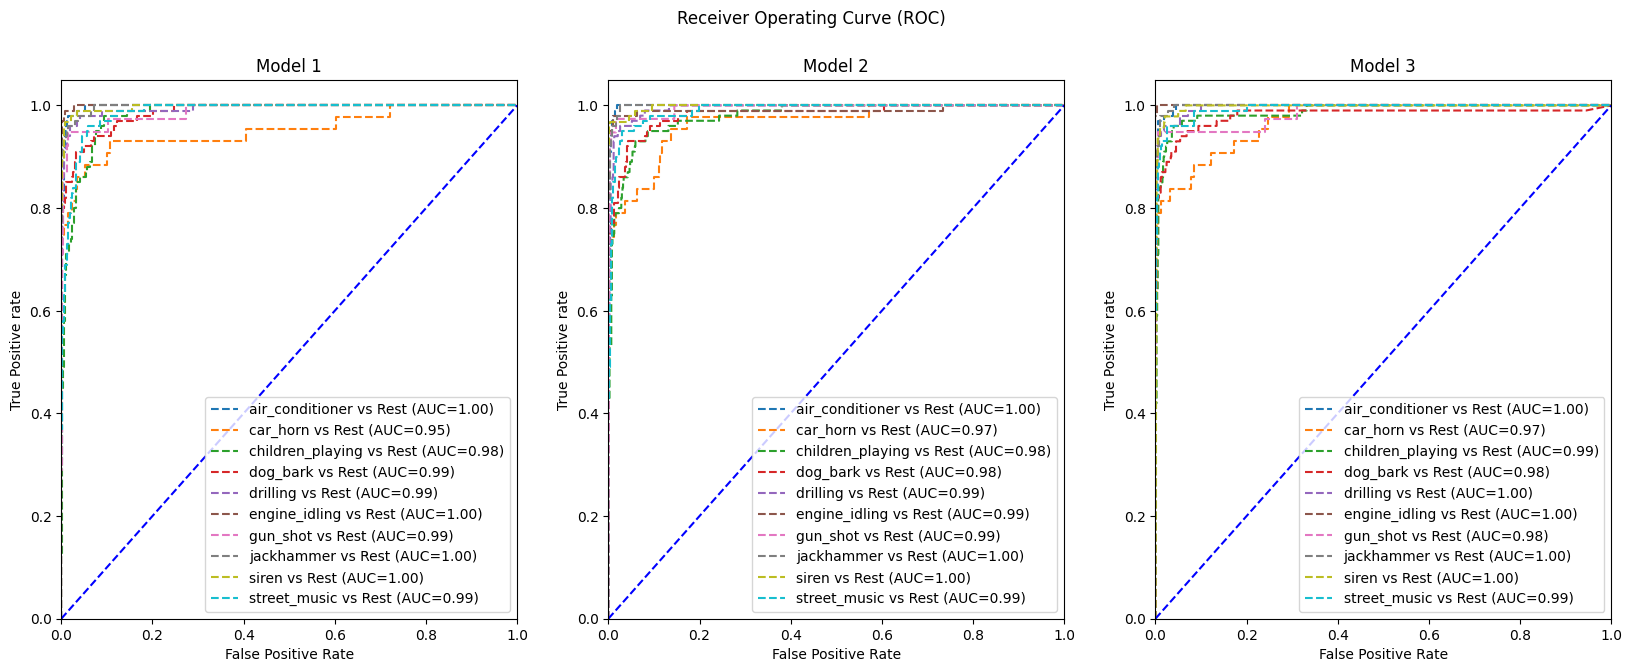

In [33]:
# Figure Setting for Subplots
fig, (axs1,axs2,axs3) = plt.subplots(1,3, figsize=(20, 7))
fig.suptitle('Receiver Operating Curve (ROC)')

# roc curves for model 1
fpr_1 = {}
tpr_1 = {}
thresh_1 ={}
roc_auc_1 = dict()
# roc curves for model  2
fpr_2 = {}
tpr_2 = {}
thresh_2 ={}
roc_auc_2 = dict()
# roc curves for model 3
fpr_3 = {}
tpr_3 = {}
thresh_3 ={}
roc_auc_3 = dict()

n_class = np.shape(classes)[0]


for i in range(n_class):    
    fpr_1[i], tpr_1[i], thresh_1[i] = roc_curve(y_test[:,i], pred_prob_1[:,i])
    roc_auc_1[i] = auc(fpr_1[i], tpr_1[i])# creating roc curve for model1
    
    fpr_2[i], tpr_2[i], thresh_2[i] = roc_curve(y_test[:,i], pred_prob_2[:,i])
    roc_auc_2[i] = auc(fpr_2[i], tpr_2[i])# creating roc curve for model2
    
    fpr_3[i], tpr_3[i], thresh_3[i] = roc_curve(y_test[:,i], pred_prob_3[:,i])
    roc_auc_3[i] = auc(fpr_3[i], tpr_3[i])# creating roc curve for model 3
    
    
    # plotting  

    axs1.plot(fpr_1[i], tpr_1[i], linestyle='--', 
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc_1[i]))
    
    axs2.plot(fpr_2[i], tpr_2[i], linestyle='--', 
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc_2[i]))

    axs3.plot(fpr_3[i], tpr_3[i], linestyle='--', 
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc_3[i]))

#Setting axis for the plots

axs1.plot([0,1],[0,1],'b--')
axs1.set_xlim([0,1])
axs1.set_ylim([0,1.05])
axs1.set_title('Model 1')
axs1.set_xlabel('False Positive Rate')
axs1.set_ylabel('True Positive rate')
axs1.legend(loc='lower right')
    
axs2.plot([0,1],[0,1],'b--')
axs2.set_xlim([0,1])
axs2.set_ylim([0,1.05])
axs2.set_title('Model 2')
axs2.set_xlabel('False Positive Rate')
axs2.set_ylabel('True Positive rate')
axs2.legend(loc='lower right')

axs3.plot([0,1],[0,1],'b--')
axs3.set_xlim([0,1])
axs3.set_ylim([0,1.05])
axs3.set_title('Model 3')
axs3.set_xlabel('False Positive Rate')
axs3.set_ylabel('True Positive rate')
axs3.legend(loc='lower right')

plt.show()

The model with most of the curves near the top right corner (close to 1) will have the highest scores. Although all the models show very good scores, we will select the third (tunned) model, that has all the scores at either 99% or 100%, with only the score for car horn at 97% which also the best in all three models and is not bad at all. Thus our best model is the third model that we optimized using random search. 

## Inferencing

In [14]:
from tensorflow.keras.models import load_model
import librosa

###### *Note*

I have created a function that can read an audio file and extract the features from the file to test it over the saved model and give predictions, but due to the library mismatch as explained before, i am not able to use it. To do inferencing, we will be using a random row from the testing set and then compare the predicted outcome with the y_test value for that row.

____________________________________________________________________________
____________________________________________________________________________
 def inference(path):
    # load the sound clip using librosa 
    audio_data, sample_rate = librosa.load(path)

    # extract mel spectrogram
    mel_spec = librosa.feature.melspectrogram(audio_data, sr=sample_rate, n_mels=10)
    #average column values of the spec array 
    mel_spec = np.mean(mel_spec, axis=1)


    # extract mfccs
    mfcc = librosa.feature.mfcc(audio_data, n_mfcc=13, sr=sample_rate)
    
    delta_mfcc = librosa.feature.delta(mfcc,mode='wrap')
    
    delta2_mfcc = librosa.feature.delta(mfcc,mode='wrap', order=2)
        
    # average column values of the mfccs arrays
    mfcc = np.mean(mfcc, axis=1)
    delta_mfcc = np.mean(delta_mfcc, axis=1)
    delta2_mfcc = np.mean(delta2_mfcc, axis=1)
    features = np.concatenate((mel_spec, mfcc, delta_mfcc, delta2_mfcc), axis=0)
    
    # convert the feature to numpy array
    features = np.array(new_features)
    # reshape the array to be accpeted by the model
    features = new_arr.reshape(1, 49)
    # use model's predict method on the array
    pred = model.predict([features])[0]
    # convert the prediction to argmax
    prediction = np.argmax(pred)
    
    classes = ['air_conditioner', 'car_horn','children_playing',
               'dog_bark','drilling','engine_idling','gun_shot',
               'jackhammer', 'siren', 'street_music']
               
    

    return classes[prediction]
______________________________________________________________________________
______________________________________________________________________________

In [16]:
import pandas as pd
Features=pd.read_csv('/home/msc1/Desktop/ADL_project/environmental_sound_classification/CW2/features.csv')

In [17]:
model = load_model('ann_tuned.h5')

2023-04-08 03:49:04.724306: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-04-08 03:49:04.786150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-08 03:49:04.786996: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.755GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2023-04-08 03:49:04.787219: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-04-08 03:49:04.788651: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-08 03:49:04.790030: I tensorflow/stream_executor/pl

In [18]:
pred = model.predict(X_test[5].reshape(1, 49))[0]

2023-04-08 03:52:44.592623: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


In [19]:
classes = ['air_conditioner', 'car_horn','children_playing',
           'dog_bark','drilling','engine_idling','gun_shot',
           'jackhammer', 'siren', 'street_music']

In [21]:
classes[np.argmax(pred)] # Our model's prediction

'siren'

In [20]:
classes[np.argmax(y_test[5])] #Actual audio class

'siren'

We can see that our model has given a right prediction.

Lets try a few more;

In [22]:
pred = model.predict(X_test[50].reshape(1, 49))[0]

In [24]:
classes[np.argmax(pred)] # Our model's prediction

'children_playing'

In [23]:
classes[np.argmax(y_test[50])] # Actual audio class

'children_playing'

In [25]:
pred = model.predict(X_test[38].reshape(1, 49))[0]

In [27]:
classes[np.argmax(pred)] # Our model's prediction

'jackhammer'

In [26]:
classes[np.argmax(y_test[38])] # Actual audio class

'jackhammer'

In [28]:
pred = model.predict(X_test[99].reshape(1, 49))[0]

classes[np.argmax(y_test[99])]



'dog_bark'

In [29]:
classes[np.argmax(pred)]

'dog_bark'

### Conclusion:

This model is capable of detecting sound of 10 different classes and can be implemented to decide if a call is an emnergency call or a false alarm by extracting the impoertant features from the audio clip and processing it using the ANN model we trained. The model has an accuracy of 92% with only 1.7% loss and a recall of 91% making this model ideal to be used in this scenario.